In [106]:
import pandas as pd
import yfinance as yf
from collections.abc import Collection
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np
from datetime import datetime, date, timedelta
import ast
import matplotlib.pyplot as plt
import statsmodels.api as sm
import requests
pd.set_option("display.max_rows", None)

In [ ]:
# TODO
# 1) this probably should pull stored values esp for back testing
# 2) maybe this should record the earliest date both assets have a price
def get_adj_close_history_df(tickers: list[str], start_date: str, end_date: str) -> pd.DataFrame:
    price_df = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        progress=False,
        auto_adjust=True
    )['Close']
    return price_df.dropna()

# NOTE: This methodology came from Caldeira & Caldeira 2013. Paper is in references folder
def is_price_series_integrated_of_order_one(
        price_series: pd.Series,
        pvalue_threshold: float = 0.05
) -> bool:
    p_level = adfuller(price_series)[1]
    # Test if series is stationary
    if p_level < pvalue_threshold:
        return False

    # Test if series is stationary after applying one difference
    p_diff = adfuller(price_series.diff().dropna())[1]
    return True if p_diff < pvalue_threshold else False


def is_pair_engle_granger_cointegrated(
        ticker1_price_series: pd.Series,
        ticker2_price_series: pd.Series,
        pvalue_threshold: float = 0.05
) -> bool:
    _, pvalue, _ = coint(ticker1_price_series, ticker2_price_series)
    return True if pvalue < pvalue_threshold else False

# TODO underwrite det_order and k_ar_diff parameter values
# current parameter values are from chatgpt
# also corroborated here https://blog.quantinsti.com/johansen-test-cointegration-building-stationary-portfolio/
def is_pair_johansen_cointegrated(
        pair_price_history_df: pd.DataFrame
) -> bool:
    johansen_cointegration_result = coint_johansen(
        pair_price_history_df.values,
        det_order=0,
        k_ar_diff=1
    )
    index_of_95_pct_confidence_level_critical_value = 1
    index_of_trace_stat = 0
    trace_stat = johansen_cointegration_result.lr1[index_of_trace_stat]
    critical_value = johansen_cointegration_result.cvt[
        0,
        index_of_95_pct_confidence_level_critical_value
    ]
    return trace_stat > critical_value
    
def is_pair_tradable(
        ticker_pair: tuple[str],
        start_date: str,
        end_date: str
) -> bool:
    try:
        pair_price_history_df = get_adj_close_history_df(ticker_pair, start_date, end_date)
        ticker1_price_series = pair_price_history_df.iloc[:,0]
        ticker2_price_series = pair_price_history_df.iloc[:,1]
        if not is_price_series_integrated_of_order_one(ticker1_price_series):
            print(f"Pair {ticker_pair} first ticker series is not I(1)")
            return False
        if not is_price_series_integrated_of_order_one(ticker2_price_series):
            print(f"Pair {ticker_pair} second ticker series is not I(1)")
            return False
        if not is_pair_engle_granger_cointegrated(ticker1_price_series, ticker2_price_series):
            print(f"Pair {ticker_pair} is not engle granger cointegrated")
            return False
        if not is_pair_johansen_cointegrated(pair_price_history_df):
            print(f"Pair {ticker_pair} is not johansen cointegrated")
            return False
        return True
    except Exception as e:
        print(f"Unable to evaluate pair {ticker_pair}")
        print(e)
        return False

def calculate_historical_gamma(
        pair_price_history_df: pd.DataFrame, 
        in_sample_start_date: datetime, 
        in_sample_end_date: datetime
) -> float:
    """
    Estimate gamma via OLS and return the spread = P1 - gamma * P2
    """
    date_mask = (pair_price_history_df.index >= in_sample_start_date) & (pair_price_history_df.index <= in_sample_end_date)
    pair_price_history_in_sample_df = pair_price_history_df[date_mask] 
    ticker1_price_series = pair_price_history_in_sample_df.iloc[:,0]
    ticker2_price_series = pair_price_history_in_sample_df.iloc[:,1]



    # Add constant to allow intercept in regression
    X = sm.add_constant(ticker2_price_series)
    model = sm.OLS(ticker1_price_series, X).fit()

    return float(model.params[1])

def calculate_spread(
        pair_price_history_df: pd.DataFrame,
        gamma: float,
        start_date: datetime, 
        end_date: datetime
) -> pd.Series:
    date_mask = (pair_price_history_df.index >= start_date) & (pair_price_history_df.index <= end_date)
    pair_price_history_out_of_sample_df = pair_price_history_df[date_mask] 
    ticker1_price_series = pair_price_history_out_of_sample_df.iloc[:,0]
    ticker2_price_series = pair_price_history_out_of_sample_df.iloc[:,1]

    return ticker1_price_series - gamma * ticker2_price_series

def calculate_trailing_zscore(spread: pd.Series, z_score_window_in_days: int, start_date: datetime, end_date: datetime) -> pd.Series:
    rolling_mean = spread.rolling(window=z_score_window_in_days).mean()
    rolling_std = spread.rolling(window=z_score_window_in_days).std()
    zscore_series = (spread - rolling_mean) / rolling_std
    zscore_filtered_series = zscore_series.loc[start_date:end_date]
    return zscore_filtered_series


# TODO add time series of prices on this graph for additional clarity
def plot_zscore_zeries(zscore_series: pd.Series):
    plt.figure(figsize=(14,6))
    plt.plot(zscore_series.index, zscore_series.values, label='Z-Score', color='blue')

    # Horizontal lines for 1 and 2 standard deviations
    for level in [1, 2]:
        plt.axhline(level, color='gray', linestyle='--', linewidth=1, label=f'+{level}σ' if level==1 else None)
        plt.axhline(-level, color='gray', linestyle='--', linewidth=1, label=f'-{level}σ' if level==1 else None)

    # Only show one label per line for legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title('Trailing Z-Score of Spread (Out-of-Sample)')
    plt.xlabel('Date')
    plt.ylabel('Z-Score')
    plt.grid(True)
    plt.show()

def get_sp_500_ticker_pairs() -> list[tuple]:
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                            "AppleWebKit/537.36 (KHTML, like Gecko) "
                            "Chrome/115.0 Safari/537.36"}
    res = requests.get(url, headers=headers)
    res.raise_for_status()
    tables = pd.read_html(res.text)
    sp500_table = tables[0]  # first table on the page
    tickers = sp500_table['Symbol'].to_list()
    pairs = []
    for ticker_one in tickers:
        for ticker_two in tickers:
            if ticker_one == ticker_two:
                continue
            pairs.append((ticker_one, ticker_two))
    return pairs
    
# TODO should eventually create a generic abstraction that takes
# a universe (list of tickers) and returns a collection of tradable pairs.
# But that computation is time consuming and I already have a list of candidate pairs
# so I'm going to start there for now.

In [ ]:
valid_pairs = []
seen_pairs = []
start_date = '2022-1-1'
end_date = '2023-12-31'


pairs = get_sp_500_ticker_pairs()

for pair in pairs:
    if sorted(pair) in seen_pairs:
        continue
    if is_pair_tradable(pair, start_date, end_date):
        print("VALID:", pair)
        valid_pairs.append(pair)
        pd.DataFrame({"Valid Pairs": [pair]}).to_csv(
                    '../data/valid_sp500_pairs.csv',
                    mode="a",      # append mode
                    header=False,  # don’t write header again
                    index=False
                )
    seen_pairs.append(sorted(pair))

/var/folders/9t/v6gpfcbs71bcpv1bsh004rrc0000gn/T/ipykernel_63239/2488512633.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return float(model.params[1])


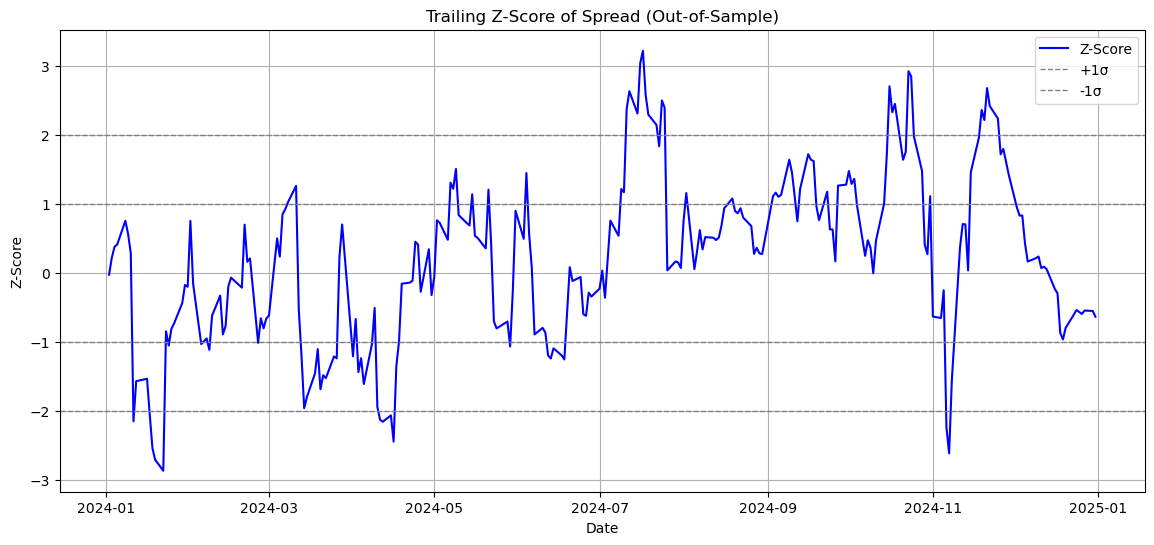

In [43]:
in_sample_start_date = datetime(2022,1,1)
in_sample_end_date = datetime(2023,12,31)

z_score_window_in_days = 50

out_of_sample_start_date = in_sample_end_date + timedelta(days=1)
out_of_sample_end_date = datetime(2025,1,1)

df = pd.read_csv('../data/valid_sp500_pairs.csv', header=None, names=['Pairs'])
df['Pairs'] = df['Pairs'].apply(ast.literal_eval)


for ticker_pair in df['Pairs'].to_list()[:1]:

    # Get prices once for entire evaluation period
    pair_price_history_df = get_adj_close_history_df(ticker_pair, in_sample_start_date, out_of_sample_end_date)
    # calculate gamma over period where cointegration has been validated
    gamma = calculate_historical_gamma(pair_price_history_df, in_sample_start_date, in_sample_end_date)

    # Lagging the out of sample start date is to ensure that there are z scores for the first day of the out of sample period
    #TODO there is a bug here bc pair price history is in trading days but the timedelta calculates in calendar days.
    # doubling the window fixed it for now but it is not precise. 
    spread_series = calculate_spread(
        pair_price_history_df,
        gamma,
        out_of_sample_start_date - timedelta(days=z_score_window_in_days*2),
        out_of_sample_end_date
    )
    out_of_sample_z_score_series = calculate_trailing_zscore(
        spread_series,
        z_score_window_in_days,
        out_of_sample_start_date,
        out_of_sample_end_date
    )
    plot_zscore_zeries(out_of_sample_z_score_series)

In [141]:
def is_exit_condition_met(
        spread_z_score_series: pd.Series,
        t_minus_one_date: datetime,
        t_minus_two_date: datetime,
        exit_threshold: float
) -> bool:
    z_score_at_t_minus_one_date = spread_z_score_series.loc[t_minus_one_date]
    z_score_at_t_minus_two_date = spread_z_score_series.loc[t_minus_two_date]
    # upwards mean reversion across exit threshold
    if z_score_at_t_minus_one_date > exit_threshold and z_score_at_t_minus_two_date < exit_threshold:
        return True
    # downwards mean reversion across exit threshold
    if z_score_at_t_minus_one_date < exit_threshold and z_score_at_t_minus_two_date > exit_threshold:
        return True
    if np.isclose(z_score_at_t_minus_one_date, exit_threshold, atol=0.1):
        return True
    return False

def get_date_of_previous_day(
        spread_z_score_series: pd.Series,
        index: int,
) -> datetime:
    return spread_z_score_series.index[index - 1]

def set_weights_to_zero_at_current_date(
        weight_at_date_df: pd.DataFrame,
        date: datetime,
        ticker_one_weight_column_name: str,
        ticker_two_weight_column_name: str,
) -> pd.DataFrame:
    weight_at_date_df.loc[date, ticker_one_weight_column_name] = 0
    weight_at_date_df.loc[date, ticker_two_weight_column_name] = 0
    return weight_at_date_df

def enter_position_at_current_date(
        weight_at_date_df: pd.DataFrame,
        date: datetime,
        ticker_one_weight_column_name: str,
        ticker_two_weight_column_name: str,
        *,
        is_long_ticker_one: bool
)  -> pd.DataFrame:
    long_position_flag = 1
    short_position_flag = -1
    if is_long_ticker_one:
        weight_at_date_df.loc[date, ticker_one_weight_column_name] = long_position_flag
        weight_at_date_df.loc[date, ticker_two_weight_column_name] = short_position_flag
    else:
        weight_at_date_df.loc[date, ticker_one_weight_column_name] = short_position_flag
        weight_at_date_df.loc[date, ticker_two_weight_column_name] = long_position_flag
    return weight_at_date_df

def assign_weights_from_prev_date_to_cur_date(
        weight_at_date_df: pd.DataFrame,
        cur_date: datetime,
        t_minus_one_date: datetime,
) -> pd.DataFrame:
    weight_at_date_df.loc[cur_date] = weight_at_date_df.loc[t_minus_one_date]
    return weight_at_date_df

def create_weights_for_spread_z_score_series(
        ticker_pair: tuple[str,str],
        spread_z_score_series: pd.Series,
) -> pd.DataFrame:
    ticker_one = ticker_pair[0]
    ticker_two = ticker_pair[1]
    weight_column_name_suffix = '_weight'
    ticker_one_weight_column_name = ticker_one + weight_column_name_suffix
    ticker_two_weight_column_name = ticker_two + weight_column_name_suffix

    weight_at_date_df = pd.DataFrame(
        index=spread_z_score_series.index,
        columns=[ticker_one_weight_column_name, ticker_two_weight_column_name]
    )
    entrance_threshold = 2
    exit_threshold = 0

    is_invested = False
    for i, (cur_date, z_score) in enumerate(spread_z_score_series.items()):
        # TODO there is a better way than to ignore the first two days. 
        # probably just extend the spread_z_score_series
        if i < 2:
            continue
        t_minus_one_date = spread_z_score_series.index[i-1]
        t_minus_two_date = spread_z_score_series.index[i-2]
        z_score_at_t_minus_one_date = spread_z_score_series.loc[t_minus_one_date]
    
        if z_score_at_t_minus_one_date >= entrance_threshold and not is_invested:
            weight_at_date_df = enter_position_at_current_date(
                weight_at_date_df,
                cur_date,
                ticker_one_weight_column_name,
                ticker_two_weight_column_name,
                is_long_ticker_one=True
            )
            is_invested = True

        elif is_invested and is_exit_condition_met(spread_z_score_series, t_minus_one_date, t_minus_two_date, exit_threshold):
            weight_at_date_df = set_weights_to_zero_at_current_date(
                                    weight_at_date_df,
                                    cur_date,
                                    ticker_one_weight_column_name,
                                    ticker_two_weight_column_name
                                )
            is_invested = False
        
        elif z_score_at_t_minus_one_date <= -entrance_threshold and not is_invested:
            weight_at_date_df = enter_position_at_current_date(
                weight_at_date_df,
                cur_date,
                ticker_one_weight_column_name,
                ticker_two_weight_column_name,
                is_long_ticker_one=False
            )
            is_invested = True
        else:
            weight_at_date_df = assign_weights_from_prev_date_to_cur_date(weight_at_date_df, cur_date, t_minus_one_date)
    
    return weight_at_date_df

In [142]:
weights_df = create_weights_for_spread_z_score_series(ticker_pair, out_of_sample_z_score_series)

In [112]:
pair_price_returns_df = pair_price_history_df.pct_change() * 100
pair_price_returns_df

Ticker,LNT,MMM
Date,,
2022-01-03,NaN,NaN
2022-01-04,-0.213643,1.400891
2022-01-05,0.889325,-0.410566
2022-01-06,-0.408114,-0.830157
2022-01-07,-0.032773,1.095533
2022-01-10,-0.590254,-1.411494
2022-01-11,-1.368971,0.884937
2022-01-12,0.551852,0.245843
2022-01-13,0.848157,0.891747


In [129]:
out_of_sample_z_score_series

Date
2024-01-02   -0.021061
2024-01-03    0.225329
2024-01-04    0.382760
2024-01-05    0.417214
2024-01-08    0.759874
2024-01-09    0.571509
2024-01-10    0.292118
2024-01-11   -2.147755
2024-01-12   -1.565574
2024-01-16   -1.530648
2024-01-17   -2.049201
2024-01-18   -2.538851
2024-01-19   -2.705376
2024-01-22   -2.863908
2024-01-23   -0.841817
2024-01-24   -1.048150
2024-01-25   -0.804626
2024-01-26   -0.726853
2024-01-29   -0.431755
2024-01-30   -0.171218
2024-01-31   -0.196249
2024-02-01    0.758230
2024-02-02   -0.150293
2024-02-05   -1.027068
2024-02-06   -0.986902
2024-02-07   -0.945846
2024-02-08   -1.111345
2024-02-09   -0.615997
2024-02-12   -0.324615
2024-02-13   -0.886785
2024-02-14   -0.764924
2024-02-15   -0.192463
2024-02-16   -0.064039
2024-02-20   -0.209243
2024-02-21    0.704168
2024-02-22    0.165526
2024-02-23    0.214629
2024-02-26   -1.009133
2024-02-27   -0.652888
2024-02-28   -0.800426
2024-02-29   -0.658321
2024-03-01   -0.613575
2024-03-04    0.504329
2024-0